In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings('ignore')

# Set device and random seeds for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Configuration
class Config:
    dataset_name = "wikitext-2-raw-v1"
    model_name = "distilgpt2"
    max_length = 128
    num_workers = 8
    pin_memory = True
    min_text_length = 50  # Minimum characters for a text to be included

config = Config()

In [4]:
# Load and preprocess dataset
def load_and_preprocess_data():
    dataset = load_dataset("wikitext", config.dataset_name)
    
    # Preprocessing function
    def preprocess(examples):
        texts = [text.strip() for text in examples["text"] 
                if len(text.strip()) > config.min_text_length 
                and not text.strip().startswith("=")]
        return {"text": texts}
    
    dataset = dataset.map(preprocess, batched=True)
    train_texts = dataset["train"]["text"][:1000]
    val_texts = dataset["validation"]["text"][:100]
    test_texts = dataset["test"]["text"][:100]
    
    return train_texts, val_texts, test_texts

In [5]:
# def load_and_preprocess_data():
#     # Load TinyStories dataset (small subset for testing)
#     dataset = load_dataset("roneneldan/TinyStories", split="train[:5000]")  # First 5K samples
    
#     # TinyStories doesn't have validation/test splits by default, so we split manually
#     dataset = dataset.train_test_split(test_size=0.2, seed=42)  # 80% train, 20% test/val
#     val_test_split = dataset["test"].train_test_split(test_size=0.5, seed=42)
    
#     # Preprocessing function (simplified since TinyStories is already clean)
#     def preprocess(examples):
#         texts = [text.strip() for text in examples["text"] 
#                 if len(text.strip()) > config.min_text_length]  # No need to filter headers ("=")
#         return {"text": texts}
    
#     # Apply preprocessing
#     train_dataset = dataset["train"].map(preprocess, batched=True)
#     val_dataset = val_test_split["train"].map(preprocess, batched=True)  # Validation
#     test_dataset = val_test_split["test"].map(preprocess, batched=True)  # Test
    
#     # Extract texts
#     train_texts = train_dataset["text"]
#     val_texts = val_dataset["text"]
#     test_texts = test_dataset["text"]
    
#     return train_texts, val_texts, test_texts

In [6]:
# Tokenizer setup
tokenizer = GPT2Tokenizer.from_pretrained(config.model_name)

# Add padding token if not already present
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})

vocab_size = len(tokenizer)

In [7]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def shuffle(self):
        np.random.shuffle(self.texts)
        
    def sort_by_length(self):
        self.texts.sort(key=lambda x: len(x))
        
    def __getitem__(self, idx):
        text = self.texts[idx]

        # Create encoding
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return encoding.input_ids.squeeze()
    

In [8]:
# Model setup
def get_model():
    model = GPT2LMHeadModel.from_pretrained(config.model_name)
    model.resize_token_embeddings(len(tokenizer))
    model = model.to(device)
    return model

In [9]:
# Loss computation
def compute_loss(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_items = 0
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            outputs = model(batch, labels=batch)
            loss = outputs.loss
            total_loss += loss.item() * batch.size(0)  # Sum losses
            total_items += batch.size(0)  # Count items
    
    # Check empty dataloader
    if total_items == 0:
        return float('nan'), float('nan')  
    
    avg_loss = total_loss / total_items  # Average loss per item
    perplexity = torch.exp(torch.tensor(avg_loss)).item()  # Perplexity
    
    return avg_loss, perplexity

In [10]:
# Training function
def train_epoch(model, dataloader, optimizer, shuffle_mode='random'):
    model.train()
    total_loss = 0
    
    if shuffle_mode == 'random':
        dataloader.dataset.shuffle()
    elif shuffle_mode == 'sorted':
        dataloader.dataset.sort_by_length()
    
    for batch in tqdm(dataloader, desc="Training", leave=False):
        batch = batch.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch, labels=batch)
        
        # Compute loss and backpropagation
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [11]:
# Experiment runner
def run_experiment(optimizer_class, lr, batch_size, epochs=5, shuffle_mode='random'):
    # Load data
    train_texts, val_texts, _ = load_and_preprocess_data()
    
    # Create datasets
    train_dataset = TextDataset(train_texts, tokenizer, config.max_length)
    val_dataset = TextDataset(val_texts, tokenizer, config.max_length)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory
    )
    
    # Initialize model
    model = get_model()
    optimizer = optimizer_class(model.parameters(), lr=lr)
    
    # Training loop
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, shuffle_mode)
        val_loss, val_perplexity = compute_loss(model, val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Perplexity: {val_perplexity:.2f}")
    
    results = {
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1],
        'val_perplexity': val_perplexity,
        'optimizer': optimizer_class.__name__,
        'lr': lr,
        'batch_size': batch_size,
        'shuffle_mode': shuffle_mode,
        'train_loss_history': train_losses,
        'val_loss_history': val_losses
    }
    
    return results

In [12]:
def plot_loss_curves(results_list):
    plt.figure(figsize=(12, 6))
    for results in results_list:
        label = f"{results['optimizer']}, lr={results['lr']}, bs={results['batch_size']}"
        plt.plot(results['train_loss_history'], label=f"Train - {label}")
        plt.plot(results['val_loss_history'], '--', label=f"Val - {label}")
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid()
    plt.show()


Running experiment with SGD, lr=0.01, bs=8, shuffle=random


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
Training:   0%|          | 0/125 [00:00<?, ?it/s]`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1/5 - Train Loss: 7.4010, Val Loss: 5.0134, Val Perplexity: 150.42


Epoch 2/5 - Train Loss: 4.9196, Val Loss: 3.5307, Val Perplexity: 34.15


Epoch 3/5 - Train Loss: 3.8552, Val Loss: 3.1152, Val Perplexity: 22.54


Epoch 4/5 - Train Loss: 3.5135, Val Loss: 2.9891, Val Perplexity: 19.87


Epoch 5/5 - Train Loss: 3.3745, Val Loss: 2.9723, Val Perplexity: 19.54


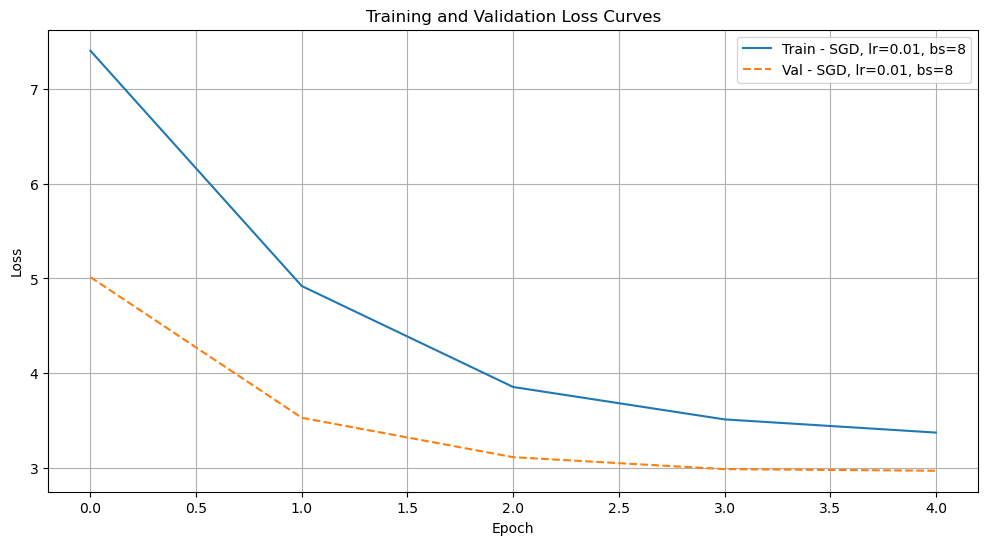


Experiment Summary:

Optimizer: SGD
LR: 0.01, Batch Size: 8, Shuffle: random
Final Train Loss: 3.3745, Val Loss: 2.9723


In [13]:
# Main experiment
def main():
    # Define experiments to run
    experiments = [
        {'optimizer_class': torch.optim.SGD, 'lr': 0.01, 'batch_size': 8, 'shuffle_mode': 'random'},
        # {'optimizer_class': torch.optim.SGD, 'lr': 0.01, 'batch_size': 8, 'shuffle_mode': 'sorted'},
        # {'optimizer_class': torch.optim.Adam, 'lr': 0.001, 'batch_size': 8, 'shuffle_mode': 'random'},
        # {'optimizer_class': torch.optim.Adam, 'lr': 0.001, 'batch_size': 8, 'shuffle_mode': 'sorted'},
        # {'optimizer_class': torch.optim.AdamW, 'lr': 0.0001, 'batch_size': 8, 'shuffle_mode': 'random'},
    ]
    
    results_list = []
    
    for exp in experiments:
        print(f"\nRunning experiment with {exp['optimizer_class'].__name__}, lr={exp['lr']}, bs={exp['batch_size']}, shuffle={exp['shuffle_mode']}")
        results = run_experiment(
            optimizer_class=exp['optimizer_class'],
            lr=exp['lr'],
            batch_size=exp['batch_size'],
            shuffle_mode=exp['shuffle_mode']
        )
        results_list.append(results)
    
    # Save results
    torch.save(results_list, 'experiment_results.pt')
    
    # Plot results
    plot_loss_curves(results_list)
    
    # Print summary
    print("\nExperiment Summary:")
    for res in results_list:
        print(f"\nOptimizer: {res['optimizer']}")
        print(f"LR: {res['lr']}, Batch Size: {res['batch_size']}, Shuffle: {res['shuffle_mode']}")
        print(f"Final Train Loss: {res['train_loss']:.4f}, Val Loss: {res['val_loss']:.4f}")

if __name__ == "__main__":
    main()